In [1]:
import os
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import pandas as pd
import random
# from src.utils import 
from network_analysis.utils import plot_graph, prepare_graph, analyze_graph, prepare_graph_for_betweenness, prepare_graph_for_degree
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
import seaborn as sns

## Make two networks

In this task, you will generate two networks based on URLs/domains posted by accounts. Define **R** as an entity (URL or top-level domain) present in a tweet. A co-action between accounts **A** and **B** occurs if:

- A and B each post a tweet within **s** seconds of each other.
- Both tweets contain the same entity **R**.

A tie is established between **A** and **B** if at least **r** co-actions occur between them. You are to generate two networks based on varying parameters:

1. **Bot Identification Network**:
   - Parameters: **s = 1 second**, **R = URLs**.
   - Reasoning: It is unlikely for two human-driven accounts to independently post the same URL at nearly the same time. This network helps identify potential bots.

2. **Ideological/Topical Group Network**:
   - Parameters: Larger **s** and **R = URLs** or **lang**?.
   - Reasoning: Accounts posting the same URL within a larger time window, even without precise synchronization, may indicate ideological or topical connections.


In [3]:
df = pd.read_csv("../../../../data/df_url_connections_s1.csv")
df[["author1", "author2"]] = df[["author1", "author2"]].astype(str)
authors = set(df["author1"])
authors.update(df["author2"])
print(f"Distinct authors: {len(authors)}")
df.info()

Distinct authors: 5279
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52269 entries, 0 to 52268
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    52269 non-null  int64  
 1   id1           52269 non-null  int64  
 2   id2           52269 non-null  int64  
 3   url           52269 non-null  object 
 4   text1         52269 non-null  object 
 5   text2         52269 non-null  object 
 6   lang1         52269 non-null  object 
 7   lang2         52269 non-null  object 
 8   author1       52269 non-null  object 
 9   author2       52269 non-null  object 
 10  time1         52269 non-null  object 
 11  time2         52269 non-null  object 
 12  seconds_diff  52269 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 5.2+ MB


In [151]:
R_MIN = 2
df_counts = df.groupby(["author1", "author2", "url"]).size().reset_index(name="r_count")
df_counts = df_counts[df_counts["r_count"] >= R_MIN]
print(df_counts.describe())
df_counts.info()

           r_count
count  1045.000000
mean     42.865072
std      64.945158
min       2.000000
25%       2.000000
50%       8.000000
75%      59.000000
max     358.000000
<class 'pandas.core.frame.DataFrame'>
Index: 1045 entries, 47 to 8509
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   author1  1045 non-null   object
 1   author2  1045 non-null   object
 2   url      1045 non-null   object
 3   r_count  1045 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 40.8+ KB


Order: 302
Size: 410
No .of Components: 87
Size of largest component: 34
Density: 0.009020703614881961
Transitivity: 0.6925819942769097


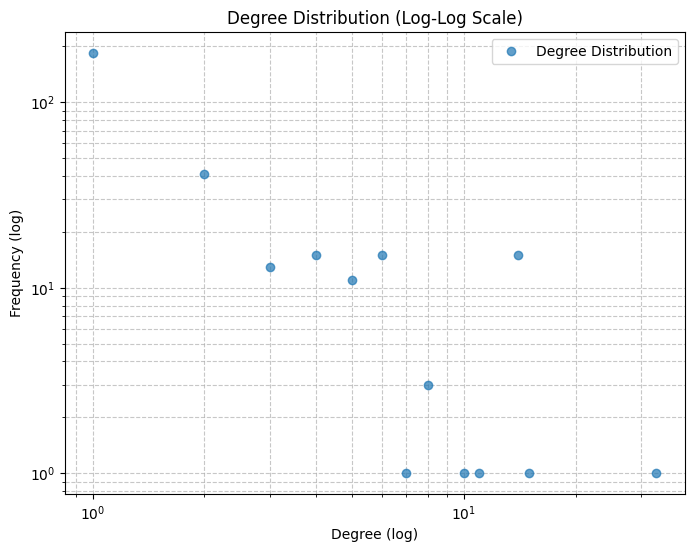

In [156]:
gbot = ig.Graph(len(authors))
gbot["title"] = "Bot Graph"
gbot.vs["name"] = list(authors)
gbot.vs["text1"] = df["text1"]
gbot.vs["text2"] = df["text2"]
gbot.vs["url"] = df["url"]
gbot.add_edges(df_counts[["author1", "author2"]].apply(tuple, axis=1).tolist())
gbot.delete_vertices([v.index for v in gbot.vs if v.degree() < 1])  # probs not needed anymore
gbot, bot_layout = prepare_graph(gbot)
analyze_graph(gbot)

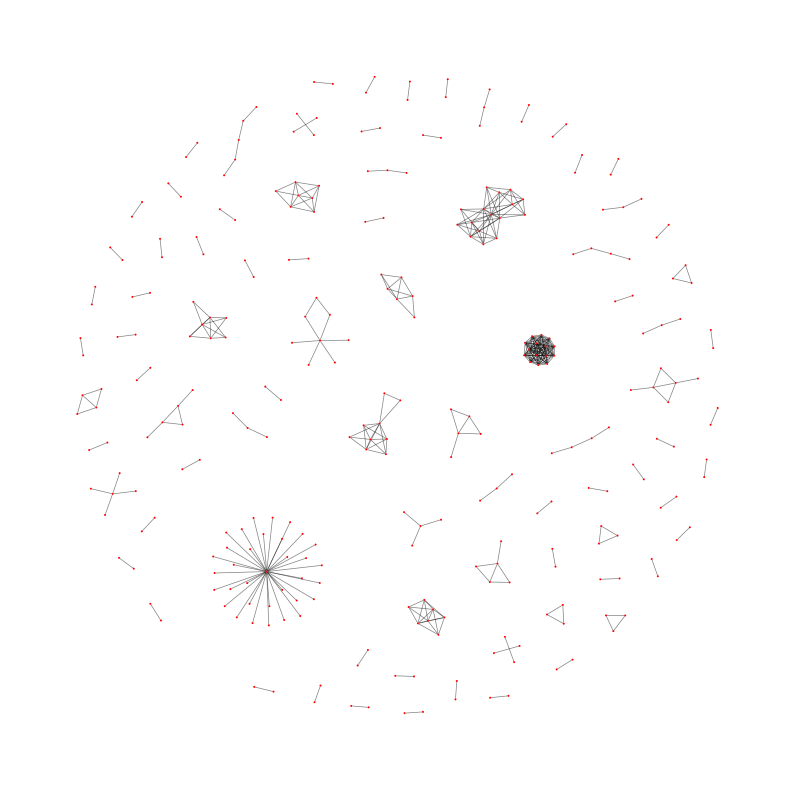

In [157]:
gbot.vs["size"] = 2
gbot.es["width"] = .5
gbot.es["color"] = "rgba(1, 1, 1, .5)"
plot_graph(gbot, gbot.layout_auto())

In [161]:
for component in gbot.components():
    if len(component) > 7:
        print(f"Component len={len(component)}")
        for field in gbot.vs[component]["text1"]:
            print(f"Field: {field}")

Component len=16
Field: Fabius has taken the floor https://t.co/sGt0YBzQLO #COP21
Field: Read latest reactions to final #COP21 draft from #climate experts in Paris on key points that matter to the poorest https://t.co/JFgq4MYPPC
Field: 0Le but de la #COP21 est de reduire la température moyenne de la planète en-dessous de 2°C d’ici #sassoui #NRCG ² https://t.co/Fa4GtCVzIw
Field: 4A Le but de la #COP21 est de reduire la température moyenne de la planète en-dessous de 2°C d’ici #sassoui #NRCG ² https://t.co/AmLSiBP087
Field: #COP21 : Denis Sassou N’Guesso a aussi parlé au nom de l’Afrique #sassoui #NRCG @moungalla @congosouverain https://t.co/CyjTUSoe0i yy
Field: Le but de la #COP21 est de reduire la température moyenne de la planète en-dessous de 2°C d’ici #sassoui #NRCG ² https://t.co/1dV544JfQL z
Field: Le but de la #COP21 est de reduire la température moyenne de la planète en-dessous de 2°C d’ici #sassoui #NRCG ² https://t.co/AmLSiBxoJx )
Field: Le but de la #COP21 est de reduire la t